In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install packaging ninja
!pip install --no-index --find-links="/content/drive/MyDrive/Colab_Lib_Backup/mamba_pkg_cu126" causal-conv1d mamba-ssm


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 17.1 MB/s eta 0:00:00
Looking in links: /content/drive/MyDrive/Colab_Lib_Backup/mamba_pkg_cu126
Processing ./drive/MyDrive/Colab_Lib_Backup/mamba_pkg_cu126/causal_conv1d-1.6.0-cp312-cp312-linux_x86_64.whl
Processing ./drive/MyDrive/Colab_Lib_Backup/mamba_pkg_cu126/mamba_ssm-2.3.0-cp312-cp312-linux_x86_64.whl


In [27]:
from mamba_ssm import Mamba2
import random
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import os
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working environment: {device}")

Working environment: cuda


In [28]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
seed_everything(42)

In [29]:
class Config:
    # Data Path
    file_path = "/content/drive/MyDrive/mamba2ncmapss/mamba2_processed.parquet"

    # Model Hyperparameters
    window_length = 1005
    batch_size = 64  # Keeping batch size low due to large window
    num_workers = 2

    input_dim = 37
    output_dim = 1 # Modified: Predicting single RUL value

    d_model = 8
    n_layers = 1
    d_state = 12
    d_head = 4

    learning_rate = 1e-4
    epochs = 50
    dropout=0.3

# Column Lists
input_cols = [
    'cycle',
    'alt', 'Mach', 'TRA', 'T2',
    'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf',
    'R_alt', 'R_Mach', 'R_TRA', 'R_T2', 'R_T24', 'R_T30', 'R_T48', 'R_T50',
    'R_P15', 'R_P2', 'R_P21', 'R_P24', 'R_Ps30', 'R_P40', 'R_P50', 'R_Nf', 'R_Nc', 'R_Wf'
]

target_cols = ['RUL']

config = Config()

In [30]:
print("Loading data...")
df = pd.read_parquet(config.file_path)

# Determine units
unique_units = df['unit'].unique()
if len(unique_units) < 2:
    raise ValueError("Dataset must have at least 2 units (one for val).")

# Last unit for validation, others for training
val_unit_id = unique_units[-1]
train_unit_ids = unique_units[:-1]

print(f"Train Units: {train_unit_ids}")
print(f"Validation Unit: {val_unit_id}")

# Train/Val Split
train_df = df[df['unit'].isin(train_unit_ids)].copy()
val_df = df[df['unit'] == val_unit_id].copy()

# Memory cleanup
del df
gc.collect()

# Normalization
# Scaler is fitted ONLY on the train set
scaler_X = StandardScaler()
scaler_y = StandardScaler()

print("Normalizing...")
# Fit_transform train data
X_train = scaler_X.fit_transform(train_df[input_cols].values)
y_train = scaler_y.fit_transform(train_df[target_cols].values)
train_meta = train_df[['unit', 'cycle']].values # Keeping metadata for sliding window logic

# Transform val data (Transform only!)
X_val = scaler_X.transform(val_df[input_cols].values)
y_val = scaler_y.transform(val_df[target_cols].values)
val_meta = val_df[['unit', 'cycle']].values

# Clear DataFrames from RAM
del train_df, val_df
gc.collect()

print("Data preparation complete.")

Loading data...
Train Units: [ 2.  5. 10. 16. 18.]
Validation Unit: 20.0
Normalizing...
Data preparation complete.


In [31]:
class LazyMambaDataset(Dataset):
    def __init__(self, X_data, y_data, meta_data, window_length):
        """
        X_data: (N, 42) Numpy array
        y_data: (N, 10) Numpy array
        meta_data: (N, 2) Numpy array (unit, cycle)
        """
        self.X_data = torch.tensor(X_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)
        self.window_length = window_length

        self.valid_indices = []

        # Calculate valid window indices
        print("Calculating indices (Lazy Indexing)...")

        # Convert metadata to DataFrame for easier grouping
        # Column 0: unit, Column 1: cycle
        # This is only for index calculation, does not copy data (meta_data is small)
        meta_df = pd.DataFrame(meta_data, columns=['unit', 'cycle'])

        # Grouping by both Unit and Cycle
        # Ensuring windows do not cross units or cycles (flights)
        for _, group in meta_df.groupby(['unit', 'cycle']):
            indices = group.index.values

            # Length of the data segment
            seq_len = len(indices)

            if seq_len <= window_length:
                continue

            # Valid start indices within this group (flight)
            # Added relative to global index (indices[0])
            start_global_idx = indices[0]

            # Example: seq_len=2050, window=2048
            # Last valid start: start + 2050 - 2048 = start + 2
            # range(start, start + 3) -> start, start+1, start+2

            last_valid_start = start_global_idx + seq_len - window_length
            self.valid_indices.extend(range(start_global_idx, last_valid_start + 1))

        print(f"Total samples (windows): {len(self.valid_indices)}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Lazy Loading: Slicing data now
        start_i = self.valid_indices[idx]
        end_i = start_i + self.window_length

        # Input: Window [T, Features]
        X_window = self.X_data[start_i : end_i]

        # Output: Many-to-One
        y_target = self.y_data[end_i - 1]

        return X_window, y_target

# Create Datasets
train_dataset = LazyMambaDataset(X_train, y_train, train_meta, config.window_length)
val_dataset = LazyMambaDataset(X_val, y_val, val_meta, config.window_length)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)

Calculating indices (Lazy Indexing)...
Total samples (windows): 4113767
Calculating indices (Lazy Indexing)...
Total samples (windows): 701896


In [32]:
class ResidualMambaBlock(nn.Module):
    """
    Standard Transformer/Mamba block structure:
    Input -> Norm -> Mamba2 -> Dropout -> Residual Connection (+ Input)
    """
    def __init__(self, config):
        super().__init__()
        self.norm = nn.LayerNorm(config.d_model)

        self.mamba = Mamba2(
            d_model=config.d_model,
            d_state=config.d_state,
            headdim=config.d_head
        )

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        # Mamba2 returns a single tensor (output), not (output, cache)
        # Pre-Norm structure: x + f(norm(x))
        z = self.norm(x)
        z = self.mamba(z)
        z = self.dropout(z)
        return x + z # Skip Connection

class Mamba2Model(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Set default dropout if not in config
        if not hasattr(config, 'dropout'):
            config.dropout = 0.1

        self.embedding = nn.Linear(config.input_dim, config.d_model)
        self.emb_dropout = nn.Dropout(config.dropout)

        # Stacking blocks
        self.layers = nn.ModuleList([
            ResidualMambaBlock(config) for _ in range(config.n_layers)
        ])

        # Final Normalization (Required for Pre-norm structure)
        self.norm_f = nn.LayerNorm(config.d_model)

        # Regression head
        self.head = nn.Linear(config.d_model, config.output_dim)

    def forward(self, x):
        # x: [Batch, Window_Length, Input_Dim]

        x = self.embedding(x)
        x = self.emb_dropout(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm_f(x)

        # Taking the last time step for regression
        x_last = x[:, -1, :]

        out = self.head(x_last)
        return out

model = Mamba2Model(config).to(device)
print(model)

Mamba2Model(
  (embedding): Linear(in_features=37, out_features=8, bias=True)
  (emb_dropout): Dropout(p=0.3, inplace=False)
  (layers): ModuleList(
    (0): ResidualMambaBlock(
      (norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (mamba): Mamba2(
        (in_proj): Linear(in_features=8, out_features=60, bias=False)
        (conv1d): Conv1d(40, 40, kernel_size=(4,), stride=(1,), padding=(3,), groups=40)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=16, out_features=8, bias=False)
      )
      (dropout): Dropout(p=0.3, inplace=False)
    )
  )
  (norm_f): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=8, out_features=1, bias=True)
)


In [33]:
def train_loop_advanced(model, train_loader, val_loader, config):
    # Parameters
    lr_patience = 4           # Reduce LR after this many epochs
    weight_decay = 0.1       # L2 Regularization
    max_lr_drops = 3          # Stop after 3rd LR reduction

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=weight_decay)

    # Scheduler: Multiply LR by 0.5 if loss doesn't decrease
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=lr_patience
    )

    best_val_loss = float('inf')
    lr_drop_count = 0
    best_model_path = "best_mamba2_model.pth"

    print(f"Training Started (L4 GPU - bfloat16 AMP Mode)... (Patience: {lr_patience}, Stop after {max_lr_drops} LR drops)")

    for epoch in range(config.epochs):
        # --- TRAINING ---
        model.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.epochs} [Train]")

        for batch_X, batch_y in train_pbar:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()

            # Mixed Precision with bfloat16 (Native support on L4/A100)
            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                outputs = model(batch_X)
                # Cast back to float32 for precise loss calculation
                loss = criterion(outputs.to(torch.float32), batch_y)

            loss.backward()

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()
            train_pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = train_loss / len(train_loader)

        # --- VALIDATION ---
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                    outputs = model(batch_X)
                    loss = criterion(outputs.to(torch.float32), batch_y)

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # --- LOGIC & SCHEDULER ---
        current_lr = optimizer.param_groups[0]['lr']

        print(f"\nEpoch {epoch+1} Results -> Train MSE: {avg_train_loss:.6f} | Val MSE: {avg_val_loss:.6f} | LR: {current_lr:.2e}")

        # 1. Save Best Model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print("--> 🏆 New best model saved.")

        # 2. Scheduler Step
        scheduler.step(avg_val_loss)
        new_lr = optimizer.param_groups[0]['lr']

        # 3. Check for LR Reduction & Stopping Condition
        if new_lr < current_lr:
            lr_drop_count += 1
            print(f"--> 📉 LR reduced! ({current_lr:.2e} -> {new_lr:.2e}). Drop count: {lr_drop_count}/{max_lr_drops}")

            if lr_drop_count >= max_lr_drops:
                print("--> 🛑 Stopping training: Reached maximum LR reductions.")
                break
            else:
                print("--> ↺ Restoring best model weights to continue with lower LR...")
                model.load_state_dict(torch.load(best_model_path))
                model.to(device)

        print("-" * 50)

# Start Training
try:
    train_loop_advanced(model, train_loader, val_loader, config)
except KeyboardInterrupt:
    print("Training stopped manually.")

Training Started (L4 GPU - bfloat16 AMP Mode)... (Patience: 4, Stop after 3 LR drops)


Epoch 1/50 [Train]:   0%|          | 0/64278 [00:00<?, ?it/s]


Epoch 1 Results -> Train MSE: 0.068844 | Val MSE: 0.067387 | LR: 1.00e-04
--> 🏆 New best model saved.
--------------------------------------------------


Epoch 2/50 [Train]:   0%|          | 0/64278 [00:00<?, ?it/s]


Epoch 2 Results -> Train MSE: 0.045463 | Val MSE: 0.109747 | LR: 1.00e-04
--------------------------------------------------


Epoch 3/50 [Train]:   0%|          | 0/64278 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e814008e2a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Training stopped manually.


Loading Test Data from /content/drive/MyDrive/mamba2ncmapss/mamba2_processed_TEST.parquet...
Normalizing Test Data...
Calculating indices (Lazy Indexing)...
Total samples (windows): 1050935
Loading Best Model...
Loaded weights from 'best_mamba2_model.pth'
Running Inference on Test Set...


Testing:   0%|          | 0/16421 [00:00<?, ?it/s]

Inverse transforming predictions...
Applying floor to predictions...

Test RMSE: 8.0240


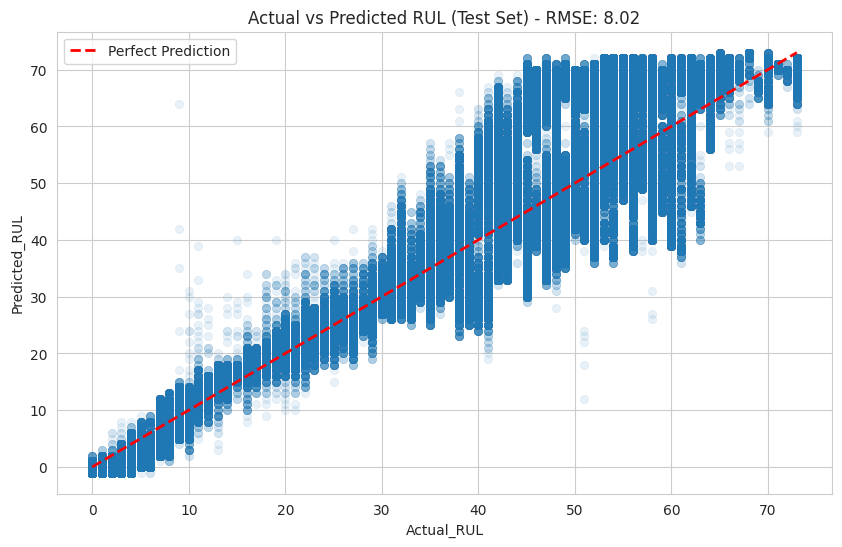

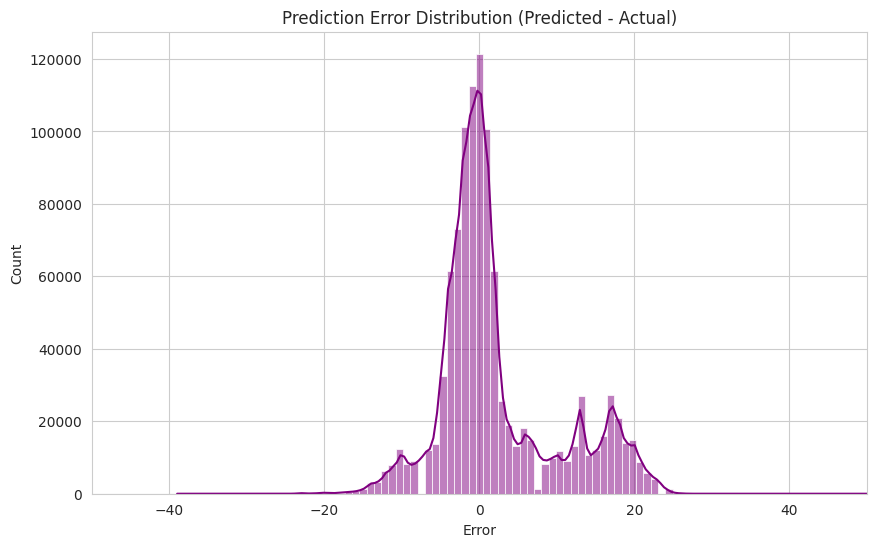

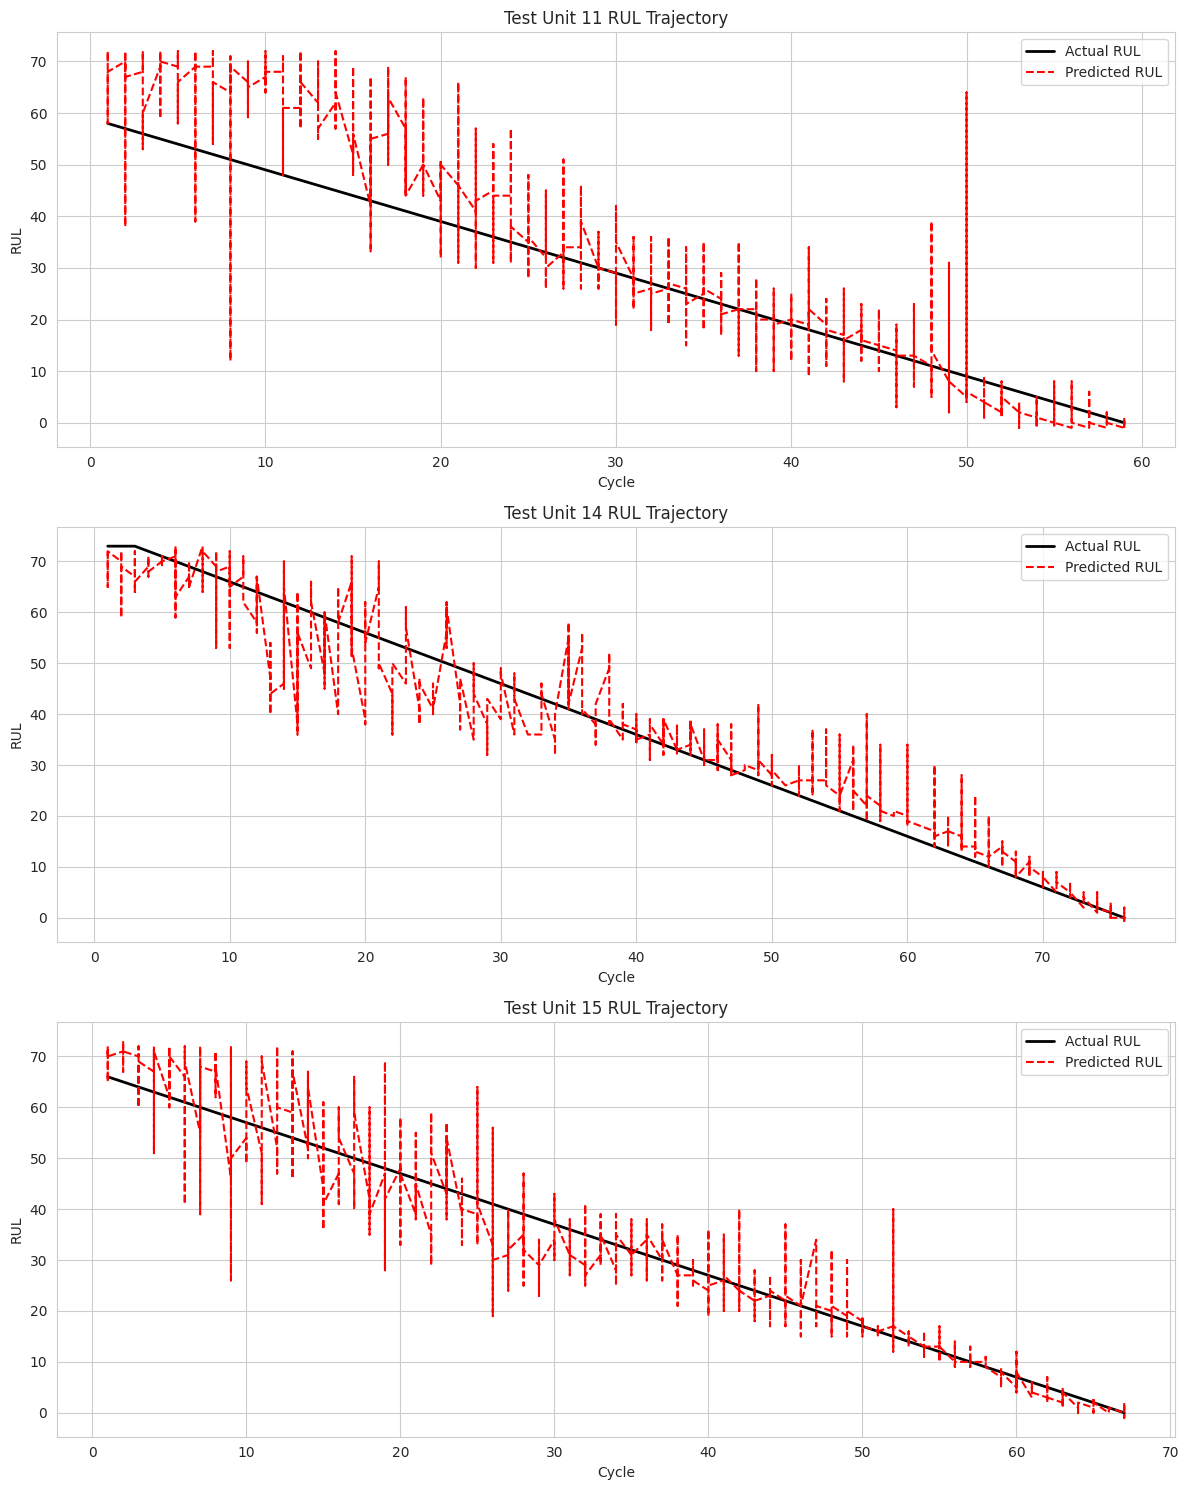

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Test Data ---
test_file_path = "/content/drive/MyDrive/mamba2ncmapss/mamba2_processed_TEST.parquet"
print(f"Loading Test Data from {test_file_path}...")
test_df = pd.read_parquet(test_file_path)

# --- 2. Preprocess ---
# Using the global scaler_X and scaler_Y fitted on training data
# and input_cols defined in Config (ensure 'cycle' is removed if you ran the previous fix)
print("Normalizing Test Data...")

# Ensure columns match
missing_cols = set(input_cols) - set(test_df.columns)
if missing_cols:
    raise ValueError(f"Missing columns in test data: {missing_cols}")

X_test = scaler_X.transform(test_df[input_cols].values)
y_test = scaler_y.transform(test_df[target_cols].values)
test_meta = test_df[['unit', 'cycle']].values

# Clear raw df to save memory
del test_df
gc.collect()

# --- 3. Create Dataset & Loader ---
# Using the existing LazyMambaDataset class
test_dataset = LazyMambaDataset(X_test, y_test, test_meta, config.window_length)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers)

# --- 4. Load Best Model ---
print("Loading Best Model...")
model = Mamba2Model(config).to(device)

try:
    model.load_state_dict(torch.load("best_mamba2_model.pth"))
    print("Loaded weights from 'best_mamba2_model.pth'")
except FileNotFoundError:
    print("Warning: 'best_mamba2_model.pth' not found. Using current model weights.")

model.eval()

# --- 5. Inference ---
print("Running Inference on Test Set...")
preds = []
targets = []

with torch.no_grad():
    for batch_X, batch_y in tqdm(test_loader, desc="Testing"):
        batch_X = batch_X.to(device)

        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            outputs = model(batch_X)

        # Move to CPU
        preds.append(outputs.float().cpu().numpy())
        targets.append(batch_y.float().cpu().numpy())

# Concatenate results
preds = np.concatenate(preds)
targets = np.concatenate(targets)

# --- 6. Inverse Transform ---
print("Inverse transforming predictions...")
preds_inv = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
targets_inv = scaler_y.inverse_transform(targets.reshape(-1, 1)).flatten()

# --- APPLY FLOORING ---
# Round down predictions as requested (e.g. 61.9 -> 61.0)
print("Applying floor to predictions...")
preds_inv = np.floor(preds_inv)

# --- 7. Prepare Results DataFrame ---
# Reconstruct Unit/Cycle info for plotting
# The dataset stores valid start indices. The target corresponds to start + window_length - 1
valid_indices_arr = np.array(test_dataset.valid_indices)
target_indices = valid_indices_arr + config.window_length - 1

pred_units = test_meta[target_indices, 0]
pred_cycles = test_meta[target_indices, 1]

results_df = pd.DataFrame({
    'Unit': pred_units,
    'Cycle': pred_cycles,
    'Actual_RUL': targets_inv,
    'Predicted_RUL': preds_inv
})

# Calculate Metrics
mse = np.mean((results_df['Actual_RUL'] - results_df['Predicted_RUL'])**2)
rmse = np.sqrt(mse)
print(f"\nTest RMSE: {rmse:.4f}")

# --- 8. Visualizations ---
sns.set_style("whitegrid")

# Plot A: Predicted vs Actual Scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual_RUL', y='Predicted_RUL', data=results_df, alpha=0.1, edgecolor=None)
plt.plot([results_df['Actual_RUL'].min(), results_df['Actual_RUL'].max()],
         [results_df['Actual_RUL'].min(), results_df['Actual_RUL'].max()],
         'r--', lw=2, label='Perfect Prediction')
plt.title(f'Actual vs Predicted RUL (Test Set) - RMSE: {rmse:.2f}')
plt.legend()
plt.show()

# Plot B: Error Histogram
plt.figure(figsize=(10, 6))
results_df['Error'] = results_df['Predicted_RUL'] - results_df['Actual_RUL']
sns.histplot(results_df['Error'], kde=True, bins=100, color='purple')
plt.title('Prediction Error Distribution (Predicted - Actual)')
plt.xlabel('Error')
plt.xlim(-50, 50) # Zoom in to see the peak
plt.show()

# Plot C: Trajectories for Sample Units
unique_test_units = results_df['Unit'].unique()
plot_units = unique_test_units[:4] # Plot first 4 units

fig, axes = plt.subplots(len(plot_units), 1, figsize=(12, 5 * len(plot_units)), sharex=False)
if len(plot_units) == 1: axes = [axes]

for i, unit in enumerate(plot_units):
    unit_data = results_df[results_df['Unit'] == unit]
    ax = axes[i]
    ax.plot(unit_data['Cycle'], unit_data['Actual_RUL'], label='Actual RUL', color='black', linewidth=2)
    ax.plot(unit_data['Cycle'], unit_data['Predicted_RUL'], label='Predicted RUL', color='red', linestyle='--')
    ax.set_title(f'Test Unit {int(unit)} RUL Trajectory')
    ax.set_ylabel('RUL')
    ax.set_xlabel('Cycle')
    ax.legend()

plt.tight_layout()
plt.show()

In [36]:
import pandas as pd
import numpy as np

# Path to the test file
test_file_path = "/content/drive/MyDrive/mamba2ncmapss/mamba2_processed_TEST.parquet"

print(f"Loading Test Data from {test_file_path} for analysis...")
df_test_check = pd.read_parquet(test_file_path)

# Get the RUL column
rul_values = df_test_check['RUL']

# Count unique values
num_unique = rul_values.nunique()

print(f"Number of unique RUL values: {num_unique}")
print(f"Total number of rows: {len(df_test_check)}")
print(f"Data type of RUL column: {rul_values.dtype}")

# Display some sample unique values (sorted)
unique_vals = np.sort(rul_values.unique())
print(f"\nSample unique RUL values (first 20):\n{unique_vals[:20]}")

# Check if all are integers
is_integer = np.all(np.equal(np.mod(unique_vals, 1), 0))
print(f"\nAre all RUL values integers? {is_integer}")

# Cleanup
del df_test_check

Loading Test Data from /content/drive/MyDrive/mamba2ncmapss/mamba2_processed_TEST.parquet for analysis...
Number of unique RUL values: 74
Total number of rows: 1253743
Data type of RUL column: float32

Sample unique RUL values (first 20):
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.]

Are all RUL values integers? True
